In [1]:
import os
import numpy as np

读取预处理分词文件

> texts：每个分词文本为一个样本
>
> labels：记录每个样本的标签

In [2]:
texts = []
labels_index = {u'健康': 0, u'教育': 1, u'财经': 2}
labels = []
TEXT_PATH = '..\preprocessing'
for name in os.listdir(TEXT_PATH):
    if name.split('.')[-1] == 'txt':
        class_name = name.split('.')[0]
        fpath = os.path.join(TEXT_PATH, name)
        with open(fpath, encoding='utf-8') as f:
            for l in f.readlines():
                texts.append(l.split(' '))
                labels.append(labels_index[class_name])
        print(fpath)
        print(class_name)

..\preprocessing\健康.txt
健康
..\preprocessing\教育.txt
教育
..\preprocessing\财经.txt
财经


统计所有文本的Token，并将文本转换为序号

> word_index：根据词频记录文本Token的序号
>
> sequences：转换为序号的文本

In [3]:
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)  # 根据词频顺序构建"词->序号"字典
sequences = tokenizer.texts_to_sequences(texts)  # 根据字典将文本转换为序号
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 139901 unique tokens.


加载词向量文件
> embedding_index：字典记录每个词的词向量

In [4]:
WORD2VEC_PATH = './sgns.sogounews.bigram-char'
embeddings_index = {}
with open(WORD2VEC_PATH, encoding='utf-8') as f:
    for l in f.readlines():
        values = l.split()
        word = values[0]
        try:
            embeddings_index[word] = np.asarray(values[1:], dtype='float32')
        except ValueError:
            word2 = values[1]
            embeddings_index[word] = np.asarray(values[2:], dtype='float32')
            embeddings_index[word2] = np.asarray(values[2:], dtype='float32')

print('Found %s word vectors.' % len(embeddings_index))

Found 364140 word vectors.


每个词的词向量矩阵
> embedding_matrix：每个词的词向量矩阵

In [5]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [6]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

pad_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)  # 将文本裁切、补足为200个词
data = np.zeros(shape=(len(sequences), MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), dtype=np.float64)
for i, pad_sequence in enumerate(pad_sequences):
    for j, word in enumerate(pad_sequence):
        data[i][j] = embedding_matrix[word]
labels = to_categorical(np.asarray(labels))  # labels采用one-hot编码
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (11470, 200, 300)
Shape of label tensor: (11470, 3)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [8]:
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


my_callbacks = [
    EarlyStopping(patience=5),
    TensorBoard(log_dir='./logs'),
    ModelCheckpoint('word2vec_LSTM.h5', monitor='val_loss', save_best_only=True, mode='auto'),
]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200, 128)          219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 359,683
Trainable params: 359,683
Non-trainable params: 0
________________________________________________

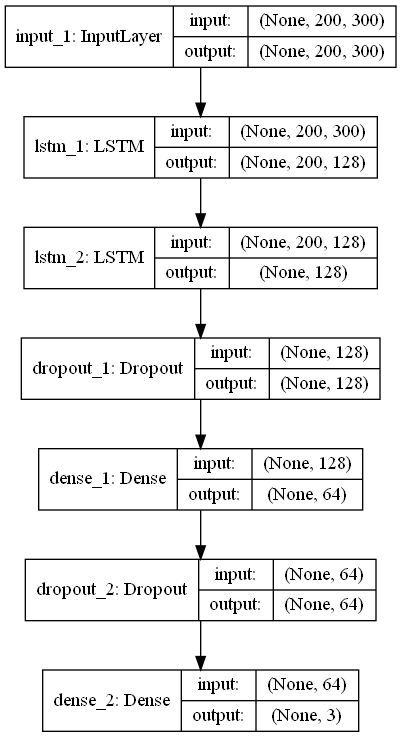

In [9]:
from keras.layers import Dense, InputLayer, Flatten, Dropout, LSTM
from keras.models import Sequential
from keras.utils import plot_model

model = Sequential()
model.add(InputLayer(input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
model.add(LSTM(128, dropout=0.3, return_sequences=True))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
model.summary()
plot_model(model, to_file='./word2vec_LSTM.png', show_shapes=True)

In [10]:
model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=my_callbacks
)

model.save('word2vec_LSTM.h5')

Train on 9176 samples, validate on 2294 samples
Epoch 1/50
9176/9176 [==============================] - 67s 7ms/step - loss: 0.5237 - accuracy: 0.8093 - f1_m: 0.7516 - precision_m: 0.8403 - recall_m: 0.7268 - val_loss: 0.2235 - val_accuracy: 0.9412 - val_f1_m: 0.9410 - val_precision_m: 0.9422 - val_recall_m: 0.9398